In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import re
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/slavaspirin/Toronto-housing-price-prediction/master/houses.csv")
original_data = df.copy()
df.head()

,index,title,final_price,list_price,bedrooms,bathrooms,sqft,parking,description,mls,type,full_link,full_address,lat,long,city_district,mean_district_income,district_code
0,0,"1303 - 38 Grenville St, Toronto (C4461599) | Z...",855000,870000,2 + 1 beds,2 baths,800–899 sq. ft.,1 parking,"Luxurious And Spacious Murano Tower. 2+1, 2 Ba...",C4461599,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"38 Grenville St, Toronto , Ontario, Canada",43.661896,-79.385748,Bay Street Corridor,56526,76
1,1,"2 Cabot Crt, Toronto (W4502992) | Zoocasa",885000,898000,3 beds,2 baths,N/A sq. ft.,6 parking,Fantastic Opportunity To Live Within The Histo...,W4502992,Semi-Detached,https://www.zoocasa.com/toronto-on-real-estate...,"2 Cabot Crt, Toronto , Ontario, Canada",43.646982,-79.530356,Islington-City Centre West,52787,14
2,2,"1504 - 30 Roehampton Ave, Toronto (C4511330) |...",550000,549900,1 beds,1 baths,500–599 sq. ft.,no parking,Bright Sunfilled Spacious 1 Bdr Unit; Floor To...,C4511330,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"30 Roehampton Ave, Toronto , Ontario, Canada",43.708472,-79.397498,Mount Pleasant West,57039,104
3,3,"514 - 65 East Liberty St, Toronto (C4515763) |...",665000,600000,1 + 1 beds,1 baths,600–699 sq. ft.,1 parking,Rare Loft-Like Condo In Liberty Village W/ 18'...,C4515763,Condo Apt,https://www.zoocasa.com/toronto-on-real-estate...,"65 East Liberty St, Toronto , Ontario, Canada",43.638399,-79.414448,Niagara,70623,82
4,4,"61 Twelfth St, Toronto (W4519375) | Zoocasa",825513,839000,2 beds,2 baths,N/A sq. ft.,1 parking,Location! Location! Location. Your Cottage In ...,W4519375,Detached,https://www.zoocasa.com/toronto-on-real-estate...,"61 Twelfth St, Toronto , Ontario, Canada",43.597096,-79.509612,New Toronto,44101,18


In [3]:
def cleansing_function(df):
    df = df.copy()
    abnType = df['type'].unique()[5] ## taking out the abnormal hosue type
    df = df[df['type']!= abnType]
    ## checking all the cities that are in the data

    '''
    we are going to split the data using the "," and then split based on teh space and get the city from each one,

    This will be added to a new column called "city"
    '''
    df["city"] = df["full_address"].apply(lambda x: x.split(",")[1].split(" ")[1].upper())
    ## now we will exclude the only row with the value "OUT" as city

    df = df[df["city"] != "OUT"]
    ## now let's clean the bedrooms column

    df["bedrooms"] = df["bedrooms"].apply(lambda x: ' '.join(x.split(" ")))

    for i,n in enumerate(df["bedrooms"]):
        df["bedrooms"].iloc[i] = max([int(s) for s in n.split() if s.isdigit()])
    ## now let's clean the bathrooms column

    df["bathrooms"] = df["bathrooms"].apply(lambda x: int(''.join(x.lower()).replace("baths", '')))
    ## now let's clean the parking column
    df["parking"] = df["parking"].apply(lambda x:    str(x).replace('no parking', '0')  )
    df["parking"] = df["parking"].apply(lambda x:    int(str(x).replace(' parking', '')  ))
    
    ## cleaning the type column

    df["type"] = df["type"].str.upper()

    for i,t in enumerate(df["type"]):
        if "APT" in t:
            df["type"].iloc[i] = "APT"
        elif "CONDO" in t:
            df["type"].iloc[i] = "CONDO"
        elif "DETACHED" in t:
            df["type"].iloc[i] = "DETACHED_HOUSE"
        elif "TWNHOUSE" in t:
            df["type"].iloc[i] = "TWNHOUSE"
    df["type"] = df["type"][df["type"] != "COTTAGE"][df["type"] != "FOURPLEX"]
    
    ## counting out rows that have bathrooms more than bedrooms
    df = df.query("bedrooms >= bathrooms")
    
    ## cleaning the sqft column and applying the average on each value
    sqft = df["sqft"].str.split(" ", 1).apply(lambda x: x[0])
    sqft.replace({"N/A": "0-0"}, inplace=True)
    sqft = sqft.apply(lambda x: re.split('–|-',x))

    sqft = sqft.apply(lambda x: min(int(x[0]) , int(x[1])))
    sqft.replace({0: np.nan}, inplace=True)
    df["sqft"] = sqft
    
    frames = []
    for room in list(set(df['bedrooms'])):
        df_rooms = df[df['bedrooms']== room]
        df_rooms['sqft'].fillna(df_rooms['sqft'].min(),inplace = True)
        frames.append(df_rooms)
    final_df = pd.concat(frames)
    final_df = final_df.reset_index().drop(columns=['index', 'level_0'])
    final_df["sqft"] = final_df["sqft"].round()
    df = final_df
    return df


In [4]:

## here we are going to categorise the final_price target
df = cleansing_function(df)
df = df[df["final_price"]<= 2000000]
df = df[df["mean_district_income"]*8 >= df["final_price"]]
df["price_category"] = np.nan
for i,price in enumerate(df["final_price"]):
    if price <= 500000:
        df["price_category"].iloc[i] = 0
    elif price <= 1000000 and price > 500000:
        df["price_category"].iloc[i] = 1
    elif price <= 1500000 and price > 1000000:
        df["price_category"].iloc[i] = 2
    elif price <= 2000000 and price > 1500000:
        df["price_category"].iloc[i] = 3
df["price_category"] = df["price_category"].astype(int)

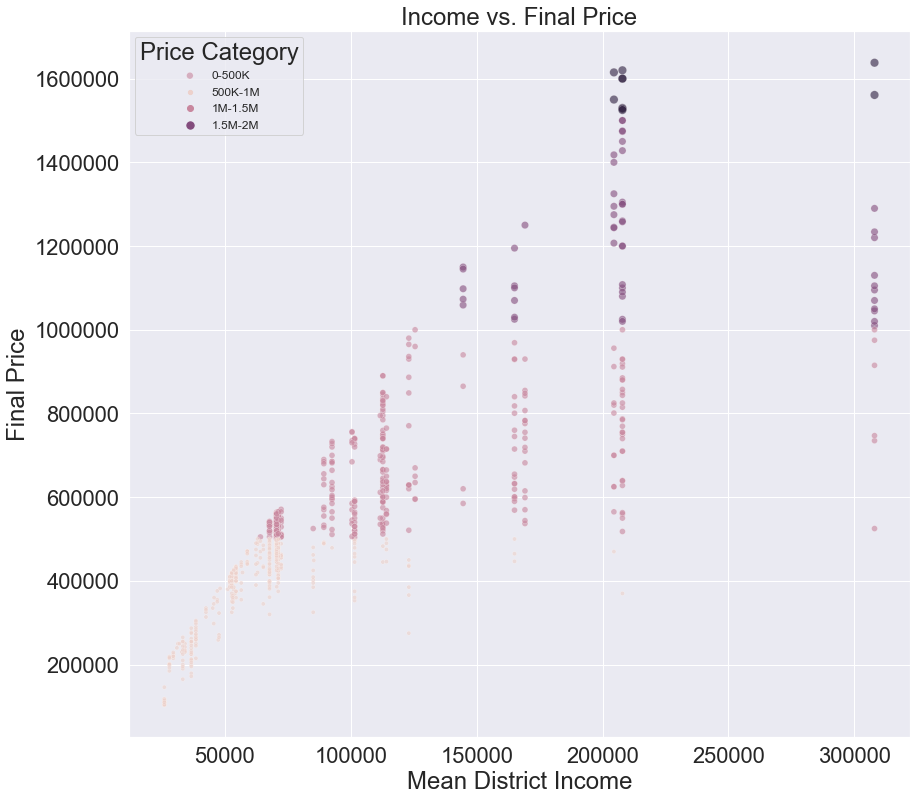

In [6]:
fig = plt.gcf()
fig.set_size_inches(14, 13)
# labelcolor=['#EFD9D4','#CA8CA2','#8A5785','#4E425C']
ax = sns.scatterplot(x="mean_district_income", y="final_price",hue = "price_category",data=df,
                     size = 'price_category',alpha = 0.6)
ax.set(xlabel='Mean District Income', ylabel='Final Price', title="Income vs. Final Price")
sns.set(font_scale = 2)
ax.legend( loc='upper left', title="Price Category", labels=['0-500K', '500K-1M', '1M-1.5M','1.5M-2M'], fontsize='12')
plt.show(ax)
